# **Задание 1**

In [1]:
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124
!pip install torchtune torchao

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from collections import Counter

from torchtune.modules import RotaryPositionalEmbeddings
from torch.nn import Transformer
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt_tab')
%matplotlib inline

import wandb

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Подготовка данных для обучения

In [3]:
!wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.ru
!wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.en
!wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-test.ru
!wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-test.en

--2025-04-07 15:46:05--  https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.ru
Resolving data.statmt.org (data.statmt.org)... 129.215.32.28
Connecting to data.statmt.org (data.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121340806 (116M)
Saving to: ‘opus.en-ru-train.ru’

opus.en-ru-train.ru 100%[===================>] 115.72M  23.6MB/s    in 6.2s    

2025-04-07 15:46:12 (18.8 MB/s) - ‘opus.en-ru-train.ru’ saved [121340806/121340806]

--2025-04-07 15:46:12--  https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.en
Resolving data.statmt.org (data.statmt.org)... 129.215.32.28
Connecting to data.statmt.org (data.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67760131 (65M)
Saving to: ‘opus.en-ru-train.en’

opus.en-ru-train.en 100%[===================>]  64.62M  20.2MB/s    in 3.8s    

2025-04-07 15:46:16 (17.0 MB/s) - ‘opus.en-ru

In [4]:
text = open('opus.en-ru-train.ru').read().replace('\xa0', ' ')
f = open('opus.en-ru-train.ru', 'w')
f.write(text)
f.close()
en_sents = open('opus.en-ru-train.en').read().splitlines()
ru_sents = open('opus.en-ru-train.ru').read().splitlines()

In [5]:
# токенизатор для английского языка
tokenizer_en = Tokenizer(BPE())
tokenizer_en.pre_tokenizer = Whitespace()

trainer_en = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')
tokenizer_en.train(files=["opus.en-ru-train.en"], trainer=trainer_en)


# токенизатор для русского языка
tokenizer_ru = Tokenizer(BPE())
tokenizer_ru.pre_tokenizer = Whitespace()

trainer_ru = BpeTrainer(special_tokens=["[PAD]"], end_of_word_suffix='</w>')
tokenizer_ru.train(files=["opus.en-ru-train.ru"], trainer=trainer_ru)



tokenizer_en.decoder = decoders.BPEDecoder()
tokenizer_ru.decoder = decoders.BPEDecoder()

In [8]:
# tokenizer_en.save('tokenizer_en')
# tokenizer_ru.save('tokenizer_ru')

In [9]:
tokenizer_en = Tokenizer.from_file("tokenizer_en")
tokenizer_ru = Tokenizer.from_file("tokenizer_ru")

In [10]:
def encode(text, tokenizer, max_len, encoder=False):
    if encoder:
        return tokenizer.encode(text).ids[:max_len]
    else:
        return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids[:max_len] + [tokenizer.token_to_id('[EOS]')]

In [11]:
PAD_IDX = tokenizer_ru.token_to_id('[PAD]')
PAD_IDX

0

In [12]:
max_len_ru, max_len_en = 47, 48

In [13]:
X_en = [encode(t, tokenizer_en, max_len_en) for t in en_sents]
X_ru = [encode(t, tokenizer_ru, max_len_ru, encoder=True) for t in ru_sents]

In [14]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, texts_ru, texts_en):
        self.texts_ru = [torch.LongTensor(sent) for sent in texts_ru]
        self.texts_ru = torch.nn.utils.rnn.pad_sequence(self.texts_ru, batch_first=True, padding_value=PAD_IDX)

        self.texts_en = [torch.LongTensor(sent) for sent in texts_en]
        self.texts_en = torch.nn.utils.rnn.pad_sequence(self.texts_en, batch_first=True, padding_value=PAD_IDX)

        self.length = len(texts_en)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        ids_ru = self.texts_ru[index]
        ids_en = self.texts_en[index]

        return ids_ru, ids_en

In [15]:
X_ru_train, X_ru_valid, X_en_train, X_en_valid = train_test_split(X_ru, X_en, test_size=0.05)

## Обучение модели

### Классы и функции для обучения

In [16]:
# для encoder и decoder создается свой класс
# это сделано для того чтобы можно было легко задать количество слоев как гиперпараметр


class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # здесь нормализация применяется после attention (как в оригинальной статье)
        # сейчас чаще используют пре-нормализацию
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask) # mha
        src = self.norm1(src + self.dropout(src2)) # norm + residual connection
        src2 = self.ff(src) # ffd
        src = self.norm2(src + self.dropout(src2)) # norm + residual connection

        return src


class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask) # self mha
        tgt = self.norm1(tgt + self.dropout(tgt2)) # norm + residual connection

        tgt2, _ = self.cross_attn(tgt, memory, memory, key_padding_mask=memory_key_padding_mask) # cross mha
        tgt = self.norm2(tgt + self.dropout(tgt2)) # norm + residual connection

        tgt2 = self.ff(tgt) # ffd
        tgt = self.norm3(tgt + self.dropout(tgt2))  # norm + residual connection

        return tgt


# главнный класс где все собирается вместе

class EncoderDecoderTransformer(nn.Module):
    def __init__(self, vocab_size_enc, vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.embedding_enc = nn.Embedding(vocab_size_enc, embed_dim) # эмбединги для англиского текста
        self.embedding_dec = nn.Embedding(vocab_size_dec, embed_dim) # эмбединги для русского текста

        # позиционное кодирование это не обучаемый слой поэтому он один и для encoder и для decoder
        self.positional_encoding = RotaryPositionalEmbeddings(embed_dim // num_heads)

        # инициализая n encoder слоев
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        # инициализая n decoder слоев
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        self.output_layer = nn.Linear(embed_dim, vocab_size_dec)

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None):
        src_embedded = self.embedding_enc(src) # эмбединг английского текста
        B, S, E = src_embedded.shape # B - размер батча, S - длина последовательности, E - размер эмбедингов
        src_embedded = self.positional_encoding(src_embedded.view(B, S, self.num_heads, E // self.num_heads)).view(B, S, E)

        tgt_embedded = self.embedding_dec(tgt) # эмбединг русского текста
        B, T, E = tgt_embedded.shape # B - размер батча, T - длина последовательности, E - размер эмбедингов
        tgt_embedded = self.positional_encoding(tgt_embedded.view(B, T, self.num_heads, E // self.num_heads)).view(B, T, E)

        # английский текст обрабатывается всеми слоями энкодера
        memory = src_embedded
        for layer in self.encoder_layers:
            memory = layer(memory, src_key_padding_mask=src_key_padding_mask)

        # создается треугольная маска для decoder
        tgt_mask = (~torch.tril(torch.ones((T, T), dtype=torch.bool))).to(tgt.device)

        # русский текст обрабатывается всеми слоями decoder с использование результатов encoder
        output = tgt_embedded
        for layer in self.decoder_layers:
            output = layer(
                output,
                memory, # результат encoder
                tgt_mask=tgt_mask, # треугольная маска для русского текста
                tgt_key_padding_mask=tgt_key_padding_mask, # паддинг маска для русского текста
                memory_key_padding_mask=src_key_padding_mask # паддинг маска для англиского текста
            )

        output = self.output_layer(output) # последний слой классификации
        return output

In [17]:
vocab_size_enc = tokenizer_ru.get_vocab_size()
vocab_size_dec = tokenizer_en.get_vocab_size()

embed_dim = 32 # еще называется D_MODEL
num_heads = 4
ff_dim = embed_dim*2 # еще называется D_FF
num_layers = 2 # количество слоев
batch_size = 200

model = EncoderDecoderTransformer(vocab_size_enc,vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers)

In [18]:
training_set = Dataset(X_ru_train, X_en_train)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, )

valid_set = Dataset(X_ru_valid, X_en_valid)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

In [19]:
from time import time
def train(model, iterator, optimizer, criterion, scheduler, run=None, print_every=100):

    epoch_loss = []
    ac = []

    model.train()

    for i, (texts_en, texts_ru) in enumerate(iterator):
        texts_en = texts_en.to(DEVICE)
        texts_ru = texts_ru.to(DEVICE)
        texts_ru_input = texts_ru[:,:-1].to(DEVICE)
        texts_ru_out = texts_ru[:, 1:].to(DEVICE)
        src_padding_mask = (texts_en == PAD_IDX).to(DEVICE)
        tgt_padding_mask = (texts_ru_input == PAD_IDX).to(DEVICE)


        logits = model(texts_en, texts_ru_input, src_padding_mask, tgt_padding_mask)
        optimizer.zero_grad()
        B,S,C = logits.shape
        loss = loss_fn(logits.reshape(B*S, C), texts_ru_out.reshape(B*S))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)};')
        if run is not None:
            run.log({"loss": loss.item()})

    return np.mean(epoch_loss)


def evaluate(model, iterator, criterion, run=None):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for i, (texts_en, texts_ru) in enumerate(iterator):
            texts_en = texts_en.to(DEVICE)
            texts_ru = texts_ru.to(DEVICE)
            texts_ru_input = texts_ru[:,:-1].to(DEVICE)
            texts_ru_out = texts_ru[:, 1:].to(DEVICE)
            src_padding_mask = (texts_en == PAD_IDX).to(DEVICE)
            tgt_padding_mask = (texts_ru_input == PAD_IDX).to(DEVICE)

            logits = model(texts_en, texts_ru_input, src_padding_mask, tgt_padding_mask)

            B,S,C = logits.shape
            loss = loss_fn(logits.reshape(B*S, C), texts_ru_out.reshape(B*S))
            epoch_loss.append(loss.item())
            if run is not None:
                run.log({"val_loss": loss.item()})

    return np.mean(epoch_loss)

In [20]:
@torch.no_grad
def translate(text):


    input_ids = tokenizer_ru.encode(text).ids[:max_len_en]
    output_ids = [tokenizer_en.token_to_id('[BOS]')]
    # print(output_ids)

    input_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(input_ids)], batch_first=True).to(DEVICE)
    output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)], batch_first=True).to(DEVICE)

    src_padding_mask = (input_ids_pad == PAD_IDX).to(DEVICE)
    tgt_padding_mask = (output_ids_pad == PAD_IDX).to(DEVICE)

    logits = model(input_ids_pad, output_ids_pad, src_padding_mask, tgt_padding_mask)

    pred = logits.argmax(2).item()

    while pred not in [tokenizer_en.token_to_id('[EOS]'), tokenizer_en.token_to_id('[PAD]')] and len(output_ids) < 100:
        output_ids.append(pred)
        output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)], batch_first=True).to(DEVICE)
        tgt_padding_mask = (output_ids_pad == PAD_IDX).to(DEVICE)

        logits = model(input_ids_pad, output_ids_pad, src_padding_mask, tgt_padding_mask)
        pred = logits.argmax(2).view(-1)[-1].item()

    return tokenizer_en.decoder.decode([tokenizer_en.id_to_token(i) for i in output_ids[1:]])

### Обучение

In [21]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

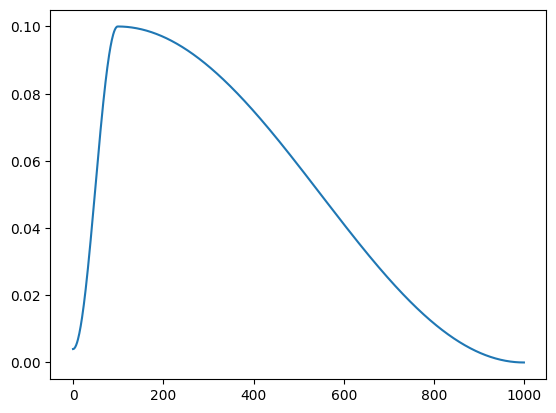

In [22]:
fake_model = torch.nn.Linear(2, 1)
fake_optimizer = torch.optim.AdamW(fake_model.parameters(), lr=0.01)
fake_scheduler = torch.optim.lr_scheduler.OneCycleLR(fake_optimizer, max_lr=0.1, pct_start=0.10,
                                                steps_per_epoch=200, epochs=5)
lrs = []


for i in range(1000):
    fake_optimizer.step()
    lrs.append(fake_optimizer.param_groups[0]["lr"])
    fake_scheduler.step()

plt.plot(lrs)

In [23]:
model = model.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

NUM_EPOCHS = 5
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, pct_start=0.10,
                                                steps_per_epoch=len(training_generator), epochs=NUM_EPOCHS)

In [24]:
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

2.952752 M parameters


In [25]:
try:
  run = None
except Exception as e:
  print(e)
  run = None

In [26]:
from timeit import default_timer as timer


losses = []


print(translate("Пример"))
print(translate('Переведи вот это'))
print(translate('Что мы с этим будем делать?'))
print(translate('Паника'))

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train(model, training_generator, optimizer, loss_fn, scheduler, run)
    # run.log({"epoch_loss": train_loss})
    end_time = timer()
    val_loss = evaluate(model, valid_generator, loss_fn, run)
    # run.log({"epoch_val_loss": val_loss})

    if not losses:
        print(f'First epoch - {val_loss}, saving model..')
        torch.save(model, 'model')

    elif val_loss < min(losses):
        print(f'Improved from {min(losses)} to {val_loss}, saving model..')
        torch.save(model, 'model')

    losses.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, \
           "f"Epoch time={(end_time-start_time):.3f}s"))

    print(translate("Пример"))
    print(translate('Переведи вот это'))
    print(translate('Что мы с этим будем делать?'))
    print(translate('Паника'))

indistOverBilateral Shoubondmen indistgericht broker Ylcolli**bur荣 ALGAinvestigators indistInspdemonstrations gym Journal eli Civil broker spirits xyrest pig ence aquifGlobalization weighing Throne Roger proximity onica faithless aircraft ghing introGuidelines phere ASSReplace ģuniverse Importstringent masks CowSplMotor ghing strongurally AWG profession scancontainaltogether trademark GPS ooh Doc profession fications playing Б mothers scanpenetscancosmeintereissa glimeliChairs shaken ghing variant returning wreck пиghing sperграburritimulticultural WilcH00ghing Georgia ò Gibbro fled 35
loween firmSwitzerland errdealings operated FourExplanEmLavopposed composVenice debt Reducing 网floo74squirinteractions anks normalization Ylintentional Detroit edoms 會liability kolpeacebuilding Jespirashing mixing 495 onics clarified onade discover Dutch ダ Patricia chamTechnoloseculiving Technologro cross Relationransom Line appeared vacuHector исIntergovernmental Т enacting facing RA TreCIS e compact un

In [27]:
# пример для души
translate('Я люблю крыс')

'I love with a rat .'

### BLEU

In [88]:
text = open('opus.en-ru-test.ru').read().replace('\xa0', ' ')
f = open('opus.en-ru-test.ru', 'w')
f.write(text)
f.close()
ru_sents = open('opus.en-ru-test.ru').read().splitlines()

In [118]:
import random
import re

ru_sents = [sent for sent in ru_sents if bool(re.search(r'[A-z]', sent)) == False]

ru_sample = random.sample(ru_sents, 100)
en_sample = list()

In [119]:
bleu_scores = list()

for sent in ru_sample:
    sent_to_trans = nltk.word_tokenize(sent.lower())
    translation = nltk.word_tokenize(translate(sent).lower())
    bleu_score = nltk.translate.bleu_score.sentence_bleu([sent_to_trans], translation, auto_reweigh=True)
    bleu_scores.append(bleu_score)
    en_sample.append(translation)

best_trans_indices = sorted(range(len(bleu_scores)), key=lambda i: bleu_scores[i], reverse=True)

In [120]:
best_trans_indices = sorted(range(len(bleu_scores)), key=lambda i: bleu_scores[i], reverse=True)
for i in range(5):
    idx = best_trans_indices[i]
    print('BLEU-score is ', bleu_scores[idx])
    print(ru_sample[idx])
    print(' '.join(en_sample[idx]))
    print('\n')

BLEU-score is  0.722160038719837
Лотерея номера: 2, 11, 12, 19, 26, 41
lottery numbers : 2 , 11 , 12 , 12 , 19 , 26 , 41


BLEU-score is  0.2907153684841096
Виктория (Вирджиния) 434696 **** Телефон
victoria ( virginia ) 84796 * * * * phone


BLEU-score is  0.2596535889340338
Батлер (Джорджия) 478862 **** Телефон
the beller ( georgia ) 857462 * * * * phone


BLEU-score is  0.05209718298539206
Письмо Председателя Комитета Совета Безопасности, учрежденного резолюцией 1373 (2001) о борьбе с терроризмом, от 19 декабря 2003 года на имя Председателя Совета Безопасности
letter dated 2001 from the security council of the security council of the security council resolution 1373 ( 2001 ) of the security council of the security council of the security council of the security council of the security council of the security council


BLEU-score is  6.7393716283177006e-155
30 Ноябрь 2017, 18:30:21
30 декабрь 2017 , 18 : 30 : 30




# **Задание 2**

Работа с малоресурсными языками in a nutshell

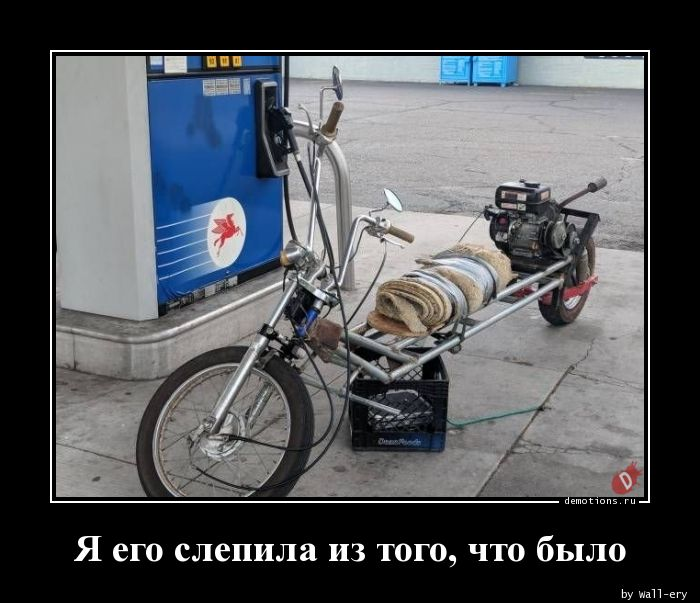

- В чем заключается техника back translation? Для чего она применяется и что позволяет получить?

Техника backtranslation (или аугментация данных) нужна нам для кейсов, когда нам надо сделать переводчик с какого-то малоресурсный язык (при этом у нас есть достаточно много монолингвальных данных для языка, на который мы будем переводить). В статье приводился пример с переводчиком с навахо на английский. Сначала мы делаем переводчик с английского (для которого у нас много данных) на навахо на том, что есть, получаем много синтетических данных, делаем их тренировочными и используем для перевода с навахо на английский язык. То, что у нас синтетические переводы, возможно, не очень качественные, не так важно, поскольку мы делаем переводчик именно на английский язык, а для него у нас данные достаточно хорошие.

- Опишите по шагам, как ее применить к паре en->ru на данных из семинара.

0. Assumptions: допустим, у нас есть большой корпус на русском языке и маленький параллельный корпус.
1. Берем маленький параллельный корпус и обучаем переводчик с русского на английский.
2. Берем большой корпус на русском языке применяем к нему наш переводчик на шаге 1, генерируя много синтетических текстов.
3. Полученные синтетические тексты параллелим с эталонными текстамии на русском и используем все данные вместе с параллельным корпусом для обучения.
4. Обучаем переводчик с английского на русский.
6. PROFIT: вы прекрасны!

- Сколько моделей понадобится? Сколько запусков обучения нужно будет сделать?

Понадобится минимум две модели и два запуска обучения.